# Part 1 (50 points)

### In this part you will implement a neural network from scratch. You cannot use any existing Deep Learning Framework. You can utilize NumPy and Pandas libraries to perform efficient calculations. Refer to Lecture 5 slides for details on computations required.
### Write a Class called NeuralNetwork that has at least the following methods (you are free to add your own methods too):
### a. Initialization method.
### b. Forward propagation method that performs forward propagation calculations.
### c. Backward propagation method that implements the backpropagation algorithm discussed in class.
### d. Train method that includes the code for gradient descent.
### e. Cost method that calculates the loss function.
### f. Predict method that calculates the predictions for the test set.
### Test your NeuralNetwork Class with the dataset you selected. If the dataset is big, you may notice inefficiencies in runtime. Try incorporating different versions of gradient descent to improve that (Minibatch, Stochastic etc.). You may choose to use only a subset of your data for this task (or any other technique). Explain which technique you followed and why.

In [8]:
import numpy as np

class NeuralNetwork:
    def __init__(self, layers_size, learning_rate=0.01):
        self.parameters = {}
        self.learning_rate = learning_rate
        self.L = len(layers_size)  

        for l in range(1, self.L):
            self.parameters['W' + str(l)] = np.random.randn(layers_size[l], layers_size[l - 1]) * 0.01
            self.parameters['b' + str(l)] = np.zeros((layers_size[l], 1))
    
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def linear_activation(self, Z):
        return Z

    def compute_mse_cost(self, Y, A):
        m = Y.shape[1]
        cost = 1/m * np.sum(np.square(Y - A))
        return cost
    
    def forward_propagation(self, X):
        cache = {'A0': X}
        for l in range(1, self.L):
            W = self.parameters['W' + str(l)]
            b = self.parameters['b' + str(l)]
            Z = np.dot(W, cache['A' + str(l - 1)]) + b
            if l == self.L - 1:  # linear
                A = self.linear_activation(Z)
            else:
                A = self.sigmoid(Z)   # sigmoid
            cache['A' + str(l)] = A
            cache['Z' + str(l)] = Z
        return A, cache
    
    def backward_propagation(self, Y, cache):
        grads = {}
        m = Y.shape[1]
        Y = Y.reshape(cache['A' + str(self.L - 1)].shape)
        
        dA = cache['A' + str(self.L - 1)] - Y
        for l in reversed(range(1, self.L)):
            Z = cache['Z' + str(l)]
            if l == self.L - 1:
                dZ = dA
            else:  
                s = self.sigmoid(Z)
                dZ = dA * s * (1 - s)
                dW = 1 / m * np.dot(dZ, cache['A' + str(l - 1)].T)
                db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
                if l > 1:
                dA = np.dot(self.parameters['W' + str(l)].T, dZ)
            
            grads['dW' + str(l)] = dW
            grads['db' + str(l)] = db
        
        return grads
    
    def update_parameters(self, grads):
        for l in range(1, self.L):
            self.parameters['W' + str(l)] -= self.learning_rate * grads['dW' + str(l)]
            self.parameters['b' + str(l)] -= self.learning_rate * grads['db' + str(l)]
    
    def train(self, X, Y, iterations=1000):
        for i in range(iterations):
            A, cache = self.forward_propagation(X)
            cost = self.compute_mse_cost(Y, A)
            grads = self.backward_propagation(Y, cache)
            self.update_parameters(grads)
            if i % 100 == 0:
                print(f"Cost after iteration {i}: {cost}")
                
    def train_with_minibatch(self, X, Y, iterations=1000, batch_size=64):
        m = X.shape[1]
        for i in range(iterations):
            epoch_cost = 0  # 每次迭代的平均成本
            num_batches = m // batch_size  # 计算需要多少个批次
            for j in range(num_batches):
                begin = j * batch_size
                end = min(begin + batch_size, X.shape[1])
                
                X_batch = X[:, begin:end]
                Y_batch = Y[:, begin:end]
                
                A, cache = self.forward_propagation(X_batch)
                cost = self.compute_mse_cost(Y_batch, A)
                epoch_cost += cost
                
                grads = self.backward_propagation(Y_batch, cache)
                self.update_parameters(grads)
            
            if i % 100 == 0:
                print(f"Cost after iteration {i}: {epoch_cost / num_batches}")


    
    def predict(self, X):
        A, _ = self.forward_propagation(X)
        return A


In [9]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import time

housing = fetch_california_housing()
X, y = housing.data, housing.target
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


layers_size = [X_train_scaled.shape[1], 16, 16, 1]
learning_rate = 0.01
nn = NeuralNetwork(layers_size, learning_rate)

start_time_standard = time.time()
nn.train(X_train_scaled.T, y_train.T, iterations=1000)  
end_time_standard = time.time()

print(f"Standard Gradient Descent Training Time: {end_time_standard - start_time_standard} seconds")

start_time_minibatch = time.time()
nn.train_with_minibatch(X_train_scaled.T, y_train.T, iterations=1000, batch_size=128)  
end_time_minibatch = time.time()

print(f"Mini-batch Gradient Descent Training Time: {end_time_minibatch - start_time_minibatch} seconds")

(20640, 8)
Cost after iteration 0: 5.6382858197139685
Cost after iteration 100: 1.3368875307069181
Cost after iteration 200: 1.3367723737507249
Cost after iteration 300: 1.3367372104002253
Cost after iteration 400: 1.3367017545026119
Cost after iteration 500: 1.3366657545794824
Cost after iteration 600: 1.3366289567204797
Cost after iteration 700: 1.3365911017546293
Cost after iteration 800: 1.336551923563995
Cost after iteration 900: 1.3365111473605986
Standard Gradient Descent Training Time: 35.46264147758484 seconds
Cost after iteration 0: 1.3368012854196707
Cost after iteration 100: 0.5987401893544131
Cost after iteration 200: 0.4549565534194603
Cost after iteration 300: 0.42954311887308044
Cost after iteration 400: 0.41200875816080773
Cost after iteration 500: 0.3999063431979154
Cost after iteration 600: 0.3906319217667973
Cost after iteration 700: 0.38380199532891046
Cost after iteration 800: 0.37944526397715045
Cost after iteration 900: 0.3767938136153682
Mini-batch Gradient Des

# Part 2 (50 points)).

### In this part you will implement a 2-layer neural network using any Deep Learning Framework (e.g., TensorFlow, PyTorch etc.).
You should pick a Deep Learning Framework that you would like to use to implement your 2-
layer Neural Network.

## Task 1 (5 points): 
Assuming you are not familiar with the framework, in this part of the homework you will present your research describing the resources you used to learn the framework (must include links to all resources). Clearly explain why you needed a particular resource for implementing a 2-layer Neural Network (NN). (Consider how you will keep track of all the computations in a NN i.e., what libraries/tools do you need within this framework.)tml



For example, some of the known resources for TensorFlow and PyTorch are:
https://www.tensorflow.org/guide/autodiff

https://www.tensorflow.org/api_docs/python/tf/GradientTape

https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

### Task 2 (35 points): Once you have figured out the resources you need for the project, you should design and implement your project. The project must include the following steps (it’s not limited to these steps): 

#### 1. Exploratory Data Analysis (Can include data cleaning, visualization etc.)
#### 2. Perform a train-dev-test split.
#### 3. Implement forward propagation (clearly describe the activation functions and other hyper-parameters you are using)

### 4. Compute the final cost function#
### 5. Implement gradient descent (any variant of gradient descent depending upon your data and project can be used) to train your model. In this step it is up to you as someone in charge of their project to improvise using optimization algorithms (Adams, RMSProp etc.) and/or regularization. Experiment with normalized inputs i.e. comment on how your model performs when the inputs are normalized. 
#### 6. Present the results using the test set.

NOTE: In this step, once you have implemented your 2-layer network you may increase and/or 
decrease the number of layers as part of the hyperparameter tuning process.#

### 1. Exploratory Data Analysis (Can include data cleaning, visualization etc.)

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
Target        0
dtype: int64


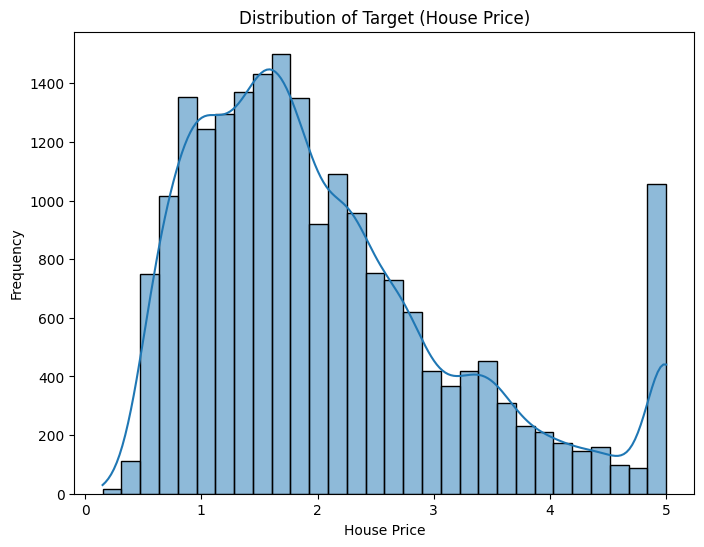

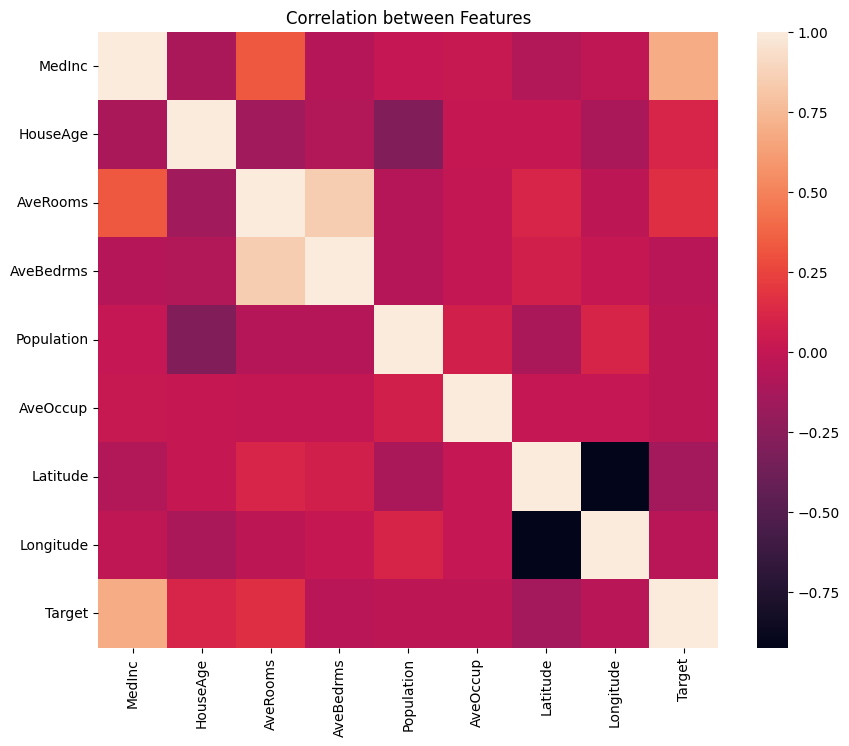

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# data cleaning & visualization
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['Target'] = housing.target

# check missing value -suppose to be no
print(df.isnull().sum())


plt.figure(figsize=(8, 6))
sns.histplot(df['Target'], bins=30, kde=True)
plt.title('Distribution of Target (House Price)')
plt.xlabel('House Price')
plt.ylabel('Frequency')
plt.show()

# heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix)
plt.title('Correlation between Features')
plt.show()


### 2. Perform a train-dev-test split2. Perform a train-dev-test split

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


housing = fetch_california_housing()
X, y = housing.data, housing.target

# load data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

### 3. Implement forward propagation (clearly describe the activation functions and other hyper-parameters you are using). 
### 4. Compute the final cost function
### 5. Implement gradient descent

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


housing = fetch_california_housing()
X, y = housing.data, housing.target

# load data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


class TwoLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x): # 3. forward propagation
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        return out

# model
input_size = X_train.shape[1]
hidden_size = 128  
output_size = 1
model = TwoLayerNN(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01) 

num_epochs = 100 
for epoch in range(num_epochs):
    # forward
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


model.eval()
with torch.no_grad():
    predictions = model(X_test)
    mse = criterion(predictions, y_test)
    print(f'Test MSE: {mse.item():.4f}')

Epoch [10/100], Loss: 1.2598
Epoch [20/100], Loss: 0.8300
Epoch [30/100], Loss: 0.6154
Epoch [40/100], Loss: 0.5405
Epoch [50/100], Loss: 0.4805
Epoch [60/100], Loss: 0.4412
Epoch [70/100], Loss: 0.4190
Epoch [80/100], Loss: 0.4051
Epoch [90/100], Loss: 0.3955
Epoch [100/100], Loss: 0.3884
Test MSE: 0.3991


Test Loss: 0.4172


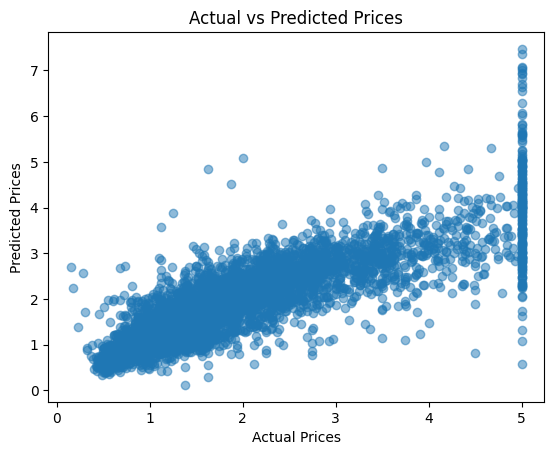

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

housing = fetch_california_housing()
X, y = housing.data, housing.target

# load data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


class TwoLayerNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(TwoLayerNN, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)  
        self.layer2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.dropout(out)  
        out = self.layer2(out)
        return out

# model
input_size = X_train.shape[1]
hidden_size = 128  
output_size = 1
model = TwoLayerNN(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

num_epochs = 100 
for epoch in range(num_epochs):
    # forward
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #if (epoch+1) % 10 == 0:
        #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

model.eval() 

with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')


predictions_np = predictions.numpy().flatten()
y_test_np = y_test.numpy().flatten()

plt.scatter(y_test_np, predictions_np, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

### Task 3 (10 points): 
#### In task 2 describe how you selected the hyperparameters. What was the rationale behind the technique you used? Did you use regularization?
#### Why, or why not? 
#### Did you use an optimization algorithm? Why or why not?
